In [6]:
#pip install pingouin

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
import pingouin as pg
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import mixedlm
import warnings
import os

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)

In [3]:
os.chdir('C:/Users/Ryo/OneDrive/Desktop/Master Thesis/master_thesis/study3')

# data preparation

## prep for the response df

In [84]:
file_loc = 'raw/Study3 - final_July_18_2024_02_35_final.xlsx'
df = pd.read_excel(file_loc)
df

,ResponseId,Ads_OP_1_Reversed,Ads_OP_2_Reversed,Ads_OP_3_Reversed,Ads_OP_4_Reversed,Ads_OP_5_Reversed,Ads_OP_6_Reversed,Ads_CO_1_Normal,Ads_CO_2_Normal,Ads_CO_3_Normal,Ads_CO_4_Normal,Ads_CO_5_Normal,Ads_CO_6_Normal,Ads_EX_1_Reversed,Ads_EX_2_Reversed,Ads_EX_3_Reversed,Ads_EX_4_Reversed,Ads_EX_5_Reversed,Ads_EX_6_Reversed,Ads_AG_1_Normal,Ads_AG_2_Normal,Ads_AG_3_Normal,Ads_AG_4_Normal,Ads_AG_5_Normal,Ads_AG_6_Normal,Desc_OP_1_Normal,Desc_CO_1_Reversed,Desc_EX_1_Normal,Desc_AG_1_Reversed
0,5db4f0b63e33f2000dd54016,22,19,14,16,17,15,21,22,18,18,18,15,24,25,23,22,21,17,70,69,69,68,65,61,75,26,75,22
1,66294a585f1cf3fdaeb80120,28,50,47,72,50,41,34,50,50,59,46,21,46,50,58,62,55,38,56,50,55,64,58,60,91,90,80,40
2,665a52573b9527ce0011158b,10,10,10,10,10,10,0,0,0,0,0,0,10,10,10,10,10,10,61,60,61,61,61,62,100,100,100,42
3,651ebcca48c60acc82f1f2bd,60,50,63,90,90,89,31,50,34,50,39,37,62,50,65,80,70,79,62,50,54,67,67,77,82,82,82,34
4,6634fb892af2e227ab65f004,80,50,90,85,90,85,80,50,75,50,75,87,95,50,95,50,95,95,70,60,70,67,70,70,10,80,60,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,64d52f62a1f1a7371760fe4f,82,64,86,72,79,90,40,44,24,37,31,15,39,31,21,21,13,13,81,73,91,68,81,89,20,70,83,32
88,66622736b3fcb6b8f3c04fdd,88,86,92,83,86,85,28,41,11,28,28,16,81,78,87,81,75,86,68,66,70,61,70,66,76,26,68,30
89,6660680acd027329cecdf2b8,37,33,35,49,47,46,61,56,67,53,74,86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
90,5d215a1bbf7f840019701939,53,52,70,62,75,82,35,49,28,40,31,33,69,69,77,64,69,68,53,54,55,51,50,50,51,52,53,53


In [18]:
print(f"shape {df.shape}")

shape (90, 29)


In [85]:
file_loc = 'raw/20240721_prolific_export.csv'
target_respondants = pd.read_csv(file_loc)
target_respondants = target_respondants[target_respondants['Status'] == 'APPROVED']['Participant id'].unique().tolist()
len(target_respondants)

90

In [86]:
study3_respondants = df['ResponseId'].tolist()
print(f"original respondse counts: {len(study3_respondants)}")

# filter df to target participants
# Count non-null values for each row
df['non_null_count'] = df.notna().sum(axis=1)

# Sort by 'ResponseId' and 'non_null_count' (descending), then drop duplicates
df = df.sort_values(['ResponseId', 'non_null_count'], ascending=[True, False]).drop_duplicates('ResponseId')

# Remove the temporary 'non_null_count' column
df = df.drop('non_null_count', axis=1)

# Filter to keep only target respondents
s3_response_df = df[df['ResponseId'].isin(target_respondants)]
print(f"final respondse counts: {len(s3_response_df['ResponseId'])}")


original respondse counts: 92
final respondse counts: 90


In [87]:
# Reverse scores for columns ending with '_Reversed'
reversed_columns = [col for col in s3_response_df.columns if col.endswith('_Reversed')]
for col in reversed_columns:
    s3_response_df[col] = 100 - s3_response_df[col]

# Remove '_Normal' or '_Reversed' from all column names
s3_response_df.columns = s3_response_df.columns.str.replace('_Normal', '').str.replace('_Reversed', '')

# Display the modified DataFrame
s3_response_df

,ResponseId,Ads_OP_1,Ads_OP_2,Ads_OP_3,Ads_OP_4,Ads_OP_5,Ads_OP_6,Ads_CO_1,Ads_CO_2,Ads_CO_3,Ads_CO_4,Ads_CO_5,Ads_CO_6,Ads_EX_1,Ads_EX_2,Ads_EX_3,Ads_EX_4,Ads_EX_5,Ads_EX_6,Ads_AG_1,Ads_AG_2,Ads_AG_3,Ads_AG_4,Ads_AG_5,Ads_AG_6,Desc_OP_1,Desc_CO_1,Desc_EX_1,Desc_AG_1
12,577f70d1454e5400015f1845,72,59,70,34,88,83,88,85,91,87,95,93,7,29,36,5,20,10,82,89,91,88,91,91,91,85,88,6
81,5a2adf6a8e00a000019864fb,72,55,64,67,58,70,27,39,35,35,22,29,74,70,82,77,75,80,80,76,76,66,77,67,72,25,26,71
33,5aa806e7777df200016088c5,20,9,0,0,0,0,16,0,6,0,11,0,16,0,2,10,4,0,62,69,54,38,48,67,84,74,23,59
63,5afe053059ae1e00017e6a3c,78,19,17,16,17,19,0,20,18,62,9,10,47,46,47,27,46,47,44,44,47,47,47,47,83,72,70,64
10,5b757a03976ecb0001b1168f,8,19,0,0,0,0,64,73,73,65,68,70,27,39,14,8,17,7,71,84,77,68,92,93,45,27,81,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,66645cff5b7cb46819ac4d8a,72,71,72,75,78,75,71,74,77,76,74,72,77,82,80,81,85,86,59,61,45,43,44,45,86,73,80,67
11,6664b0106c4f8ba1febc5a1a,17,30,21,8,14,9,78,68,75,0,73,91,23,30,4,38,22,22,36,73,81,0,91,41,74,14,69,30
84,6665899df8740e0a2b6798fa,16,8,11,6,10,14,89,93,86,88,91,88,15,5,12,10,10,8,94,90,87,90,92,88,91,75,88,79
19,666667f3e900925d27fe40d7,11,11,3,5,5,7,91,75,100,81,84,87,94,94,87,90,100,95,79,88,92,90,88,100,100,98,87,93


## prep for socioecnomic and big5 scores

In [23]:
big5_file_loc = 'raw/big5_scores.csv'
big5_df = pd.read_csv(big5_file_loc)
big5_df.tail(5)

,ResponseId,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Open_Mindedness
99,60a062ed4c4334abbbf32323,3.333333,3.000000,3.166667,3.666667,4.166667
100,5f3ac1732efa0a74f975b1a8,3.500000,4.833333,4.333333,1.000000,3.000000
101,6601b51675d287d6a62f11c4,3.666667,4.833333,4.333333,1.166667,4.666667
102,656f2e99bd2939f9b3f9d090,3.833333,4.000000,4.666667,1.666667,4.000000
103,6658822c0f5b1367a1585ee1,4.500000,4.666667,5.000000,1.333333,3.166667


In [24]:
socioecono_file_loc = 'raw/socioecono_scores.csv'
socioecono_df = pd.read_csv(socioecono_file_loc)
socioecono_df.tail(5)

,ResponseId,gender,age,education,race,employment,income
99,60a062ed4c4334abbbf32323,2,27,4,2,1,1
100,5f3ac1732efa0a74f975b1a8,2,30,2,1,6,5
101,6601b51675d287d6a62f11c4,2,55,5,2,99,11
102,656f2e99bd2939f9b3f9d090,1,43,5,2,7,12
103,6658822c0f5b1367a1585ee1,2,43,5,2,7,8


In [25]:
# filter socioecono_df and big5_df to study3 participants
socioecono_df = socioecono_df[socioecono_df['ResponseId'].isin(target_respondants)]
big5_df = big5_df[big5_df['ResponseId'].isin(target_respondants)]
print(f"row # for socioecono_df : {len(socioecono_df['ResponseId'])}, row # for big5_df : {len(big5_df['ResponseId'])}")

row # for socioecono_df : 90, row # for big5_df : 90


# general analysis

In [26]:
print(f"mean age {socioecono_df['age'].mean()} with sd {socioecono_df['age'].std()}, female % {socioecono_df[socioecono_df['gender']==1]['gender'].sum()/socioecono_df.shape[0]}")

mean age 40.86666666666667 with sd 11.74466170869495, female % 0.4777777777777778


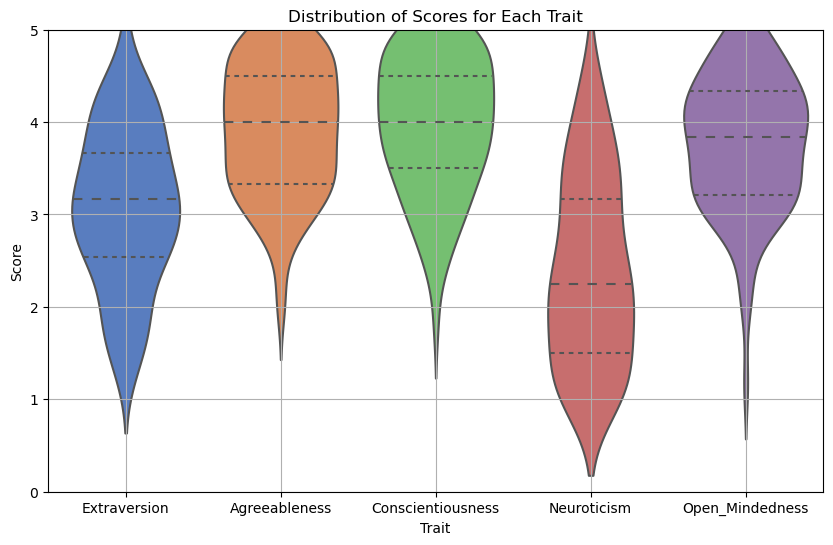

In [30]:
# Melt the DataFrame
big5_df_num = big5_df.iloc[:,1:]
big5_df_melted = big5_df_num.melt(var_name='Trait', value_name='Score')

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Trait', y='Score', data=big5_df_melted, inner='quartile', palette='muted')
plt.title('Distribution of Scores for Each Trait')
plt.ylim(0, 5)
plt.xlabel('Trait')
plt.ylabel('Score')
plt.grid(True)

# Show the plot
plt.show()

# generating distance_df for mixed personality trait

In [33]:
# Extract rows where all Big 5 scores are greater than 3
big5_df_high_scorers = big5_df[
                               (big5_df['Extraversion'] > 3) & 
                               (big5_df['Agreeableness'] > 3) & 
                               (big5_df['Conscientiousness'] > 3) & 
                               (big5_df['Open_Mindedness'] > 3)
]

# Display the result
print(f"Number of participants with targeted Big 5 scores > 3: {len(big5_df_high_scorers)}")
#print(big5_df_high_scorers)

Number of participants with targeted Big 5 scores > 3: 32


In [42]:
# Extract rows where all Big 5 scores are greater than 3
big5_df_ex_high_scorers = big5_df[big5_df['Extraversion'] > 3]['ResponseId'].tolist()
big5_df_ag_high_scorers = big5_df[big5_df['Agreeableness'] > 3]['ResponseId'].tolist()
big5_df_co_high_scorers = big5_df[big5_df['Conscientiousness'] > 3]['ResponseId'].tolist()
big5_df_op_high_scorers = big5_df[big5_df['Open_Mindedness'] > 3]['ResponseId'].tolist()

# Display the result
print(f"Number of participants with op > 3: {len(big5_df_op_high_scorers)}")
print(f"Number of participants with co > 3: {len(big5_df_co_high_scorers)}")
print(f"Number of participants with ex > 3: {len(big5_df_ex_high_scorers)}")
print(f"Number of participants with ag > 3: {len(big5_df_ag_high_scorers)}")

big5_dfs_dict = {}
big5_dfs_dict['op'] = big5_df[big5_df['ResponseId'].isin(big5_df_op_high_scorers)]
big5_dfs_dict['co'] = big5_df[big5_df['ResponseId'].isin(big5_df_co_high_scorers)]
big5_dfs_dict['ex'] = big5_df[big5_df['ResponseId'].isin(big5_df_ex_high_scorers)]
big5_dfs_dict['ag'] = big5_df[big5_df['ResponseId'].isin(big5_df_ag_high_scorers)]

Number of participants with op > 3: 75
Number of participants with co > 3: 77
Number of participants with ex > 3: 46
Number of participants with ag > 3: 79


In [38]:
socioecono_df_high_op = socioecono_df[socioecono_df['ResponseId'].isin(big5_df_op_high_scorers)]
socioecono_df_high_co = socioecono_df[socioecono_df['ResponseId'].isin(big5_df_co_high_scorers)]
socioecono_df_high_ex = socioecono_df[socioecono_df['ResponseId'].isin(big5_df_ex_high_scorers)]
socioecono_df_high_ag = socioecono_df[socioecono_df['ResponseId'].isin(big5_df_ag_high_scorers)]


print(f"OP: mean age {socioecono_df_high_op['age'].mean()} with sd {socioecono_df_high_op['age'].std()}, female % {socioecono_df_high_op[socioecono_df_high_op['gender']==1]['gender'].sum()/socioecono_df_high_op.shape[0]}")
print(f"CO: mean age {socioecono_df_high_co['age'].mean()} with sd {socioecono_df_high_co['age'].std()}, female % {socioecono_df_high_co[socioecono_df_high_co['gender']==1]['gender'].sum()/socioecono_df_high_co.shape[0]}")
print(f"EX: mean age {socioecono_df_high_ex['age'].mean()} with sd {socioecono_df_high_ex['age'].std()}, female % {socioecono_df_high_ex[socioecono_df_high_ex['gender']==1]['gender'].sum()/socioecono_df_high_ex.shape[0]}")
print(f"AG: mean age {socioecono_df_high_ag['age'].mean()} with sd {socioecono_df_high_ag['age'].std()}, female % {socioecono_df_high_ag[socioecono_df_high_ag['gender']==1]['gender'].sum()/socioecono_df_high_ag.shape[0]}")

socioecono_dfs_dict = {}
socioecono_dfs_dict['op'] = socioecono_df_high_op
socioecono_dfs_dict['co'] = socioecono_df_high_co
socioecono_dfs_dict['ex'] = socioecono_df_high_ex
socioecono_dfs_dict['ag'] = socioecono_df_high_ag

OP: mean age 40.653333333333336 with sd 11.715655191946228, female % 0.44
CO: mean age 41.675324675324674 with sd 12.262954008379054, female % 0.4935064935064935
EX: mean age 41.608695652173914 with sd 11.408531429241043, female % 0.5652173913043478
AG: mean age 40.40506329113924 with sd 11.88461512201834, female % 0.46835443037974683


In [37]:
mixed_trait_scores = pd.read_csv('raw/mixed_trait_scores.csv')
mixed_trait_scores

,Extraversion,Agreeableness,Conscientiousness,Open_Mindedness
0,3.166667,4.0,4.0,3.833333


In [43]:
big5_dfs_dict['op']

,ResponseId,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Open_Mindedness
1,641357b26802e397b5627d5e,3.833333,3.166667,4.166667,1.833333,4.166667
2,66294a585f1cf3fdaeb80120,4.166667,3.166667,4.666667,1.833333,3.166667
3,661571d6cc16ee34676734df,3.166667,3.333333,3.000000,4.000000,4.166667
4,6629f95a14b6006e6a4b0aef,3.000000,4.333333,3.500000,2.666667,4.166667
5,66463d8b1984a328f78252d7,3.166667,3.666667,2.333333,3.500000,5.000000
...,...,...,...,...,...,...
94,666667f3e900925d27fe40d7,1.833333,2.000000,2.666667,4.333333,4.666667
95,63c0e1b1ee5ca75f61e3b2e1,4.500000,3.333333,3.833333,1.500000,4.000000
96,5d4a6459061e2a000138bad3,3.666667,4.333333,4.666667,2.166667,5.000000
101,6601b51675d287d6a62f11c4,3.666667,4.833333,4.333333,1.166667,4.666667


In [44]:
big5_dict = {'op': 'Open_Mindedness',
             'co': 'Conscientiousness',
             'ex': 'Extraversion',
             'ag': 'Agreeableness'}
    




In [79]:
def calculate_distance(df, mixed_scores, trait):
    trait_full = big5_dict[trait]
    return np.abs(df[trait_full] - mixed_scores[trait_full].values[0])

def calculate_distance_from_max(df, trait):
    trait_full = big5_dict[trait]
    return 5 - df[trait_full]

def generate_big5_distance_df(big5_df, mixed_trait_scores):
    distances = pd.DataFrame(index=big5_df.index)
    
    for trait in big5_dict.keys():
        distances[f'{trait}_distance'] = calculate_distance(big5_df, mixed_trait_scores, trait)
        distances[f'{trait}_distance_from_max'] = calculate_distance_from_max(big5_df, trait)
    
    distances['total_distance'] = distances[[f'{trait}_distance' for trait in big5_dict.keys()]].sum(axis=1)
    
    distance_columns = [f'{trait}_distance' for trait in big5_dict.keys()]
    distances['average_distance'] = distances[distance_columns].mean(axis=1)
    
    return pd.concat([big5_df['ResponseId'], distances], axis=1)

def generate_big5_distance_type_df(df, mixed_trait_scores):
    distances = pd.DataFrame(index=df.index)
    
    for trait in big5_dict.keys():
        distances[f'{trait}_distance'] = calculate_distance(df, mixed_trait_scores, trait)
        distances[f'{trait}_distance_from_max'] = calculate_distance_from_max(df, trait)
    
    distances['total_distance'] = distances[[f'{trait}_distance' for trait in big5_dict.keys()]].sum(axis=1)
    
    distance_columns = [f'{trait}_distance' for trait in big5_dict.keys()]
    distances['average_distance'] = distances[distance_columns].mean(axis=1)
    
    return pd.concat([df['ResponseId'], distances], axis=1)

# Generate big5_distance_df for all respondents
big5_distance_df = generate_big5_distance_df(big5_df, mixed_trait_scores)

# Generate big5_distance_{type} for each type
big5_distance_dfs_dict = {}
for type, df in big5_dfs_dict.items():
    big5_distance_dfs_dict[type] = generate_big5_distance_type_df(df, mixed_trait_scores)
    globals()[f'big5_distance_{type}'] = big5_distance_dfs_dict[type]

# Display summary statistics for the comprehensive DataFrame
print("Summary for all responses:")
print(big5_distance_df.describe())
print("\n")

# Display top 5 closest participants based on total distance for all responses
print("Top 5 closest participants for all responses based on total distance:")
print(big5_distance_df.sort_values('total_distance').head())
print("\n" + "="*50 + "\n")

# Display summary statistics and top 5 closest participants for each type
for type, df in big5_distance_dfs_dict.items():
    print(f"Summary for {type.upper()}:")
    print(df.describe())
    print("\n")
    
    print(f"Top 5 closest participants for {type.upper()} based on total distance:")
    print(df.sort_values('total_distance').head())
    print("\n" + "="*50 + "\n")

Summary for all responses:
       op_distance  op_distance_from_max  co_distance  co_distance_from_max  \
count    90.000000             90.000000    90.000000             90.000000   
mean      0.587037              1.235185     0.609259              1.038889   
std       0.440766              0.733493     0.423381              0.743700   
min       0.000000              0.000000     0.000000              0.000000   
25%       0.333333              0.666667     0.333333              0.500000   
50%       0.500000              1.166667     0.500000              1.000000   
75%       0.833333              1.791667     0.833333              1.500000   
max       2.666667              3.833333     2.166667              3.166667   

       ex_distance  ex_distance_from_max  ag_distance  ag_distance_from_max  \
count    90.000000             90.000000    90.000000             90.000000   
mean      0.694444              1.920370     0.585185              1.081481   
std       0.509124      

In [77]:
for key, value in big5_distance_dfs_dict.items():
    print(key)
    print(value.head())
    print("")

op
                 ResponseId  op_distance  op_distance_from_max  co_distance  \
1  641357b26802e397b5627d5e     0.333333              0.833333     0.166667   
2  66294a585f1cf3fdaeb80120     0.666667              1.833333     0.666667   
3  661571d6cc16ee34676734df     0.333333              0.833333     1.000000   
4  6629f95a14b6006e6a4b0aef     0.333333              0.833333     0.500000   
5  66463d8b1984a328f78252d7     1.166667              0.000000     1.666667   

   co_distance_from_max  ex_distance  ex_distance_from_max  ag_distance  \
1              0.833333     0.666667              1.166667     0.833333   
2              0.333333     1.000000              0.833333     0.833333   
3              2.000000     0.000000              1.833333     0.666667   
4              1.500000     0.166667              2.000000     0.333333   
5              2.666667     0.000000              1.833333     0.333333   

   ag_distance_from_max  total_distance  average_distance  
1          

<Axes: >

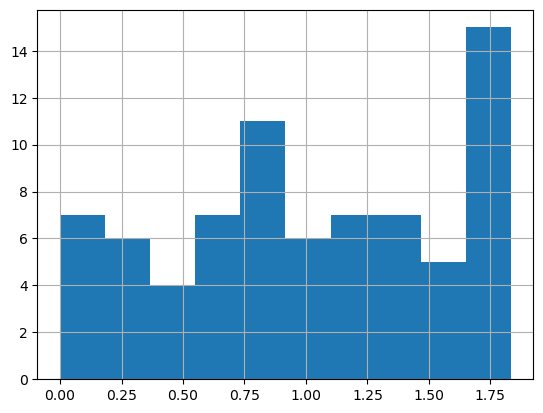

In [107]:
from_max_cols = ['op_distance_from_max',
                 'co_distance_from_max',
                 'ex_distance_from_max',
                 'ag_distance_from_max']

big5_distance_dfs_dict['op'][from_max_cols[0]].hist()

#big5_distance_dfs_dict['op']

In [110]:
op_filtered_rows = big5_distance_dfs_dict['op'][big5_distance_dfs_dict['op'][from_max_cols[0]] < 1]
co_filtered_rows = big5_distance_dfs_dict['co'][big5_distance_dfs_dict['co'][from_max_cols[1]] < 1]
ex_filtered_rows = big5_distance_dfs_dict['ex'][big5_distance_dfs_dict['ex'][from_max_cols[2]] < 1]
ag_filtered_rows = big5_distance_dfs_dict['ag'][big5_distance_dfs_dict['ag'][from_max_cols[3]] < 1]

print(f"op: {op_filtered_rows.shape[0]}")
print(f"co: {co_filtered_rows.shape[0]}")
print(f"ex: {ex_filtered_rows.shape[0]}")
print(f"ag: {ag_filtered_rows.shape[0]}")

op: 35
co: 42
ex: 15
ag: 39


<Axes: >

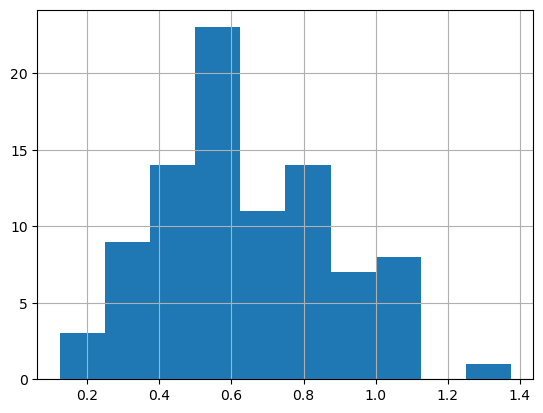

In [104]:
big5_distance_df['average_distance'].hist()

In [63]:
big5_distance_dfs_dict['op']

,ResponseId,op_distance,op_distance_from_max,co_distance,co_distance_from_max,ex_distance,ex_distance_from_max,ag_distance,ag_distance_from_max,total_distance,average_distance
1,641357b26802e397b5627d5e,0.333333,0.833333,0.166667,0.833333,0.666667,1.166667,0.833333,1.833333,2.000000,0.500000
2,66294a585f1cf3fdaeb80120,0.666667,1.833333,0.666667,0.333333,1.000000,0.833333,0.833333,1.833333,3.166667,0.791667
3,661571d6cc16ee34676734df,0.333333,0.833333,1.000000,2.000000,0.000000,1.833333,0.666667,1.666667,2.000000,0.500000
4,6629f95a14b6006e6a4b0aef,0.333333,0.833333,0.500000,1.500000,0.166667,2.000000,0.333333,0.666667,1.333333,0.333333
5,66463d8b1984a328f78252d7,1.166667,0.000000,1.666667,2.666667,0.000000,1.833333,0.333333,1.333333,3.166667,0.791667
...,...,...,...,...,...,...,...,...,...,...,...
94,666667f3e900925d27fe40d7,0.833333,0.333333,1.333333,2.333333,1.333333,3.166667,2.000000,3.000000,5.500000,1.375000
95,63c0e1b1ee5ca75f61e3b2e1,0.166667,1.000000,0.166667,1.166667,1.333333,0.500000,0.666667,1.666667,2.333333,0.583333
96,5d4a6459061e2a000138bad3,1.166667,0.000000,0.666667,0.333333,0.500000,1.333333,0.333333,0.666667,2.666667,0.666667
101,6601b51675d287d6a62f11c4,0.833333,0.333333,0.333333,0.666667,0.500000,1.333333,0.833333,0.166667,2.500000,0.625000


# data prep for mixed effect model

In [80]:
big5_distance_df

,ResponseId,op_distance,op_distance_from_max,co_distance,co_distance_from_max,ex_distance,ex_distance_from_max,ag_distance,ag_distance_from_max,total_distance,average_distance
1,641357b26802e397b5627d5e,0.333333,0.833333,0.166667,0.833333,0.666667,1.166667,0.833333,1.833333,2.000000,0.500000
2,66294a585f1cf3fdaeb80120,0.666667,1.833333,0.666667,0.333333,1.000000,0.833333,0.833333,1.833333,3.166667,0.791667
3,661571d6cc16ee34676734df,0.333333,0.833333,1.000000,2.000000,0.000000,1.833333,0.666667,1.666667,2.000000,0.500000
4,6629f95a14b6006e6a4b0aef,0.333333,0.833333,0.500000,1.500000,0.166667,2.000000,0.333333,0.666667,1.333333,0.333333
5,66463d8b1984a328f78252d7,1.166667,0.000000,1.666667,2.666667,0.000000,1.833333,0.333333,1.333333,3.166667,0.791667
...,...,...,...,...,...,...,...,...,...,...,...
96,5d4a6459061e2a000138bad3,1.166667,0.000000,0.666667,0.333333,0.500000,1.333333,0.333333,0.666667,2.666667,0.666667
98,62b473736986d2b27c1427d2,1.166667,2.333333,0.333333,1.333333,1.000000,0.833333,0.500000,1.500000,3.000000,0.750000
100,5f3ac1732efa0a74f975b1a8,0.833333,2.000000,0.333333,0.666667,0.333333,1.500000,0.833333,0.166667,2.333333,0.583333
101,6601b51675d287d6a62f11c4,0.833333,0.333333,0.333333,0.666667,0.500000,1.333333,0.833333,0.166667,2.500000,0.625000


In [88]:
s3_response_df

,ResponseId,Ads_OP_1,Ads_OP_2,Ads_OP_3,Ads_OP_4,Ads_OP_5,Ads_OP_6,Ads_CO_1,Ads_CO_2,Ads_CO_3,Ads_CO_4,Ads_CO_5,Ads_CO_6,Ads_EX_1,Ads_EX_2,Ads_EX_3,Ads_EX_4,Ads_EX_5,Ads_EX_6,Ads_AG_1,Ads_AG_2,Ads_AG_3,Ads_AG_4,Ads_AG_5,Ads_AG_6,Desc_OP_1,Desc_CO_1,Desc_EX_1,Desc_AG_1
12,577f70d1454e5400015f1845,72,59,70,34,88,83,88,85,91,87,95,93,7,29,36,5,20,10,82,89,91,88,91,91,91,85,88,6
81,5a2adf6a8e00a000019864fb,72,55,64,67,58,70,27,39,35,35,22,29,74,70,82,77,75,80,80,76,76,66,77,67,72,25,26,71
33,5aa806e7777df200016088c5,20,9,0,0,0,0,16,0,6,0,11,0,16,0,2,10,4,0,62,69,54,38,48,67,84,74,23,59
63,5afe053059ae1e00017e6a3c,78,19,17,16,17,19,0,20,18,62,9,10,47,46,47,27,46,47,44,44,47,47,47,47,83,72,70,64
10,5b757a03976ecb0001b1168f,8,19,0,0,0,0,64,73,73,65,68,70,27,39,14,8,17,7,71,84,77,68,92,93,45,27,81,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,66645cff5b7cb46819ac4d8a,72,71,72,75,78,75,71,74,77,76,74,72,77,82,80,81,85,86,59,61,45,43,44,45,86,73,80,67
11,6664b0106c4f8ba1febc5a1a,17,30,21,8,14,9,78,68,75,0,73,91,23,30,4,38,22,22,36,73,81,0,91,41,74,14,69,30
84,6665899df8740e0a2b6798fa,16,8,11,6,10,14,89,93,86,88,91,88,15,5,12,10,10,8,94,90,87,90,92,88,91,75,88,79
19,666667f3e900925d27fe40d7,11,11,3,5,5,7,91,75,100,81,84,87,94,94,87,90,100,95,79,88,92,90,88,100,100,98,87,93


In [90]:
# Merge big5_distance_df and s3_response_df on ResponseId
merged_df = pd.merge(big5_distance_df, s3_response_df, on='ResponseId', how='inner')

# Rename columns in the merged dataframe
column_mapping = {
    'op_distance': 'OP_distance',
    'op_distance_from_max': 'OP_distance_from_max',
    'co_distance': 'CO_distance',
    'co_distance_from_max': 'CO_distance_from_max',
    'ex_distance': 'EX_distance',
    'ex_distance_from_max': 'EX_distance_from_max',
    'ag_distance': 'AG_distance',
    'ag_distance_from_max': 'AG_distance_from_max'
}

merged_df = merged_df.rename(columns=column_mapping)

# Display the column names to verify the changes
print("\nColumn names:")
print(merged_df.columns)



Column names:
Index(['ResponseId', 'OP_distance', 'OP_distance_from_max', 'CO_distance',
       'CO_distance_from_max', 'EX_distance', 'EX_distance_from_max',
       'AG_distance', 'AG_distance_from_max', 'total_distance',
       'average_distance', 'Ads_OP_1', 'Ads_OP_2', 'Ads_OP_3', 'Ads_OP_4',
       'Ads_OP_5', 'Ads_OP_6', 'Ads_CO_1', 'Ads_CO_2', 'Ads_CO_3', 'Ads_CO_4',
       'Ads_CO_5', 'Ads_CO_6', 'Ads_EX_1', 'Ads_EX_2', 'Ads_EX_3', 'Ads_EX_4',
       'Ads_EX_5', 'Ads_EX_6', 'Ads_AG_1', 'Ads_AG_2', 'Ads_AG_3', 'Ads_AG_4',
       'Ads_AG_5', 'Ads_AG_6', 'Desc_OP_1', 'Desc_CO_1', 'Desc_EX_1',
       'Desc_AG_1'],
      dtype='object')


In [91]:
merged_df

,ResponseId,OP_distance,OP_distance_from_max,CO_distance,CO_distance_from_max,EX_distance,EX_distance_from_max,AG_distance,AG_distance_from_max,total_distance,average_distance,Ads_OP_1,Ads_OP_2,Ads_OP_3,Ads_OP_4,Ads_OP_5,Ads_OP_6,Ads_CO_1,Ads_CO_2,Ads_CO_3,Ads_CO_4,Ads_CO_5,Ads_CO_6,Ads_EX_1,Ads_EX_2,Ads_EX_3,Ads_EX_4,Ads_EX_5,Ads_EX_6,Ads_AG_1,Ads_AG_2,Ads_AG_3,Ads_AG_4,Ads_AG_5,Ads_AG_6,Desc_OP_1,Desc_CO_1,Desc_EX_1,Desc_AG_1
0,641357b26802e397b5627d5e,0.333333,0.833333,0.166667,0.833333,0.666667,1.166667,0.833333,1.833333,2.000000,0.500000,89,75,89,84,71,75,81,66,74,77,79,82,72,68,67,68,76,69,71,78,70,68,85,84,63,50,53,50
1,66294a585f1cf3fdaeb80120,0.666667,1.833333,0.666667,0.333333,1.000000,0.833333,0.833333,1.833333,3.166667,0.791667,72,50,53,28,50,59,34,50,50,59,46,21,54,50,42,38,45,62,56,50,55,64,58,60,91,10,80,60
2,661571d6cc16ee34676734df,0.333333,0.833333,1.000000,2.000000,0.000000,1.833333,0.666667,1.666667,2.000000,0.500000,29,49,37,45,34,31,60,60,58,59,62,80,61,100,56,57,61,67,65,59,59,59,65,71,28,49,57,57
3,6629f95a14b6006e6a4b0aef,0.333333,0.833333,0.500000,1.500000,0.166667,2.000000,0.333333,0.666667,1.333333,0.333333,37,37,40,42,40,41,64,66,71,60,66,66,33,34,38,35,36,35,64,62,59,60,62,66,68,62,65,36
4,66463d8b1984a328f78252d7,1.166667,0.000000,1.666667,2.666667,0.000000,1.833333,0.333333,1.333333,3.166667,0.791667,13,39,33,23,40,15,81,73,77,85,61,84,16,21,20,30,14,26,20,40,8,28,18,16,14,94,65,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,5d4a6459061e2a000138bad3,1.166667,0.000000,0.666667,0.333333,0.500000,1.333333,0.333333,0.666667,2.666667,0.666667,48,73,48,48,48,47,11,40,10,10,9,10,93,52,96,95,95,95,14,80,14,46,17,44,7,26,54,47
86,62b473736986d2b27c1427d2,1.166667,2.333333,0.333333,1.333333,1.000000,0.833333,0.500000,1.500000,3.000000,0.750000,72,27,27,40,17,30,71,88,26,26,68,82,33,15,76,30,70,13,74,26,66,25,68,45,21,28,84,68
87,5f3ac1732efa0a74f975b1a8,0.833333,2.000000,0.333333,0.666667,0.333333,1.500000,0.833333,0.166667,2.333333,0.583333,5,14,0,3,31,0,24,0,26,0,46,0,29,1,3,50,28,23,81,58,77,60,51,59,100,59,0,11
88,6601b51675d287d6a62f11c4,0.833333,0.333333,0.333333,0.666667,0.500000,1.333333,0.833333,0.166667,2.500000,0.625000,18,44,19,23,20,24,33,45,34,40,39,35,18,40,17,17,20,22,71,83,79,75,82,89,45,44,83,57


In [95]:
merged_df

,ResponseId,OP_distance,OP_distance_from_max,CO_distance,CO_distance_from_max,EX_distance,EX_distance_from_max,AG_distance,AG_distance_from_max,total_distance,average_distance,Ads_OP_1,Ads_OP_2,Ads_OP_3,Ads_OP_4,Ads_OP_5,Ads_OP_6,Ads_CO_1,Ads_CO_2,Ads_CO_3,Ads_CO_4,Ads_CO_5,Ads_CO_6,Ads_EX_1,Ads_EX_2,Ads_EX_3,Ads_EX_4,Ads_EX_5,Ads_EX_6,Ads_AG_1,Ads_AG_2,Ads_AG_3,Ads_AG_4,Ads_AG_5,Ads_AG_6,Desc_OP_1,Desc_CO_1,Desc_EX_1,Desc_AG_1
0,641357b26802e397b5627d5e,0.333333,0.833333,0.166667,0.833333,0.666667,1.166667,0.833333,1.833333,2.000000,0.500000,89,75,89,84,71,75,81,66,74,77,79,82,72,68,67,68,76,69,71,78,70,68,85,84,63,50,53,50
1,66294a585f1cf3fdaeb80120,0.666667,1.833333,0.666667,0.333333,1.000000,0.833333,0.833333,1.833333,3.166667,0.791667,72,50,53,28,50,59,34,50,50,59,46,21,54,50,42,38,45,62,56,50,55,64,58,60,91,10,80,60
2,661571d6cc16ee34676734df,0.333333,0.833333,1.000000,2.000000,0.000000,1.833333,0.666667,1.666667,2.000000,0.500000,29,49,37,45,34,31,60,60,58,59,62,80,61,100,56,57,61,67,65,59,59,59,65,71,28,49,57,57
3,6629f95a14b6006e6a4b0aef,0.333333,0.833333,0.500000,1.500000,0.166667,2.000000,0.333333,0.666667,1.333333,0.333333,37,37,40,42,40,41,64,66,71,60,66,66,33,34,38,35,36,35,64,62,59,60,62,66,68,62,65,36
4,66463d8b1984a328f78252d7,1.166667,0.000000,1.666667,2.666667,0.000000,1.833333,0.333333,1.333333,3.166667,0.791667,13,39,33,23,40,15,81,73,77,85,61,84,16,21,20,30,14,26,20,40,8,28,18,16,14,94,65,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,5d4a6459061e2a000138bad3,1.166667,0.000000,0.666667,0.333333,0.500000,1.333333,0.333333,0.666667,2.666667,0.666667,48,73,48,48,48,47,11,40,10,10,9,10,93,52,96,95,95,95,14,80,14,46,17,44,7,26,54,47
86,62b473736986d2b27c1427d2,1.166667,2.333333,0.333333,1.333333,1.000000,0.833333,0.500000,1.500000,3.000000,0.750000,72,27,27,40,17,30,71,88,26,26,68,82,33,15,76,30,70,13,74,26,66,25,68,45,21,28,84,68
87,5f3ac1732efa0a74f975b1a8,0.833333,2.000000,0.333333,0.666667,0.333333,1.500000,0.833333,0.166667,2.333333,0.583333,5,14,0,3,31,0,24,0,26,0,46,0,29,1,3,50,28,23,81,58,77,60,51,59,100,59,0,11
88,6601b51675d287d6a62f11c4,0.833333,0.333333,0.333333,0.666667,0.500000,1.333333,0.833333,0.166667,2.500000,0.625000,18,44,19,23,20,24,33,45,34,40,39,35,18,40,17,17,20,22,71,83,79,75,82,89,45,44,83,57


array([[<Axes: title={'center': 'OP_distance'}>,
        <Axes: title={'center': 'OP_distance_from_max'}>,
        <Axes: title={'center': 'CO_distance'}>],
       [<Axes: title={'center': 'CO_distance_from_max'}>,
        <Axes: title={'center': 'EX_distance'}>,
        <Axes: title={'center': 'EX_distance_from_max'}>],
       [<Axes: title={'center': 'AG_distance'}>,
        <Axes: title={'center': 'AG_distance_from_max'}>,
        <Axes: title={'center': 'total_distance'}>],
       [<Axes: title={'center': 'average_distance'}>, <Axes: >, <Axes: >]],
      dtype=object)

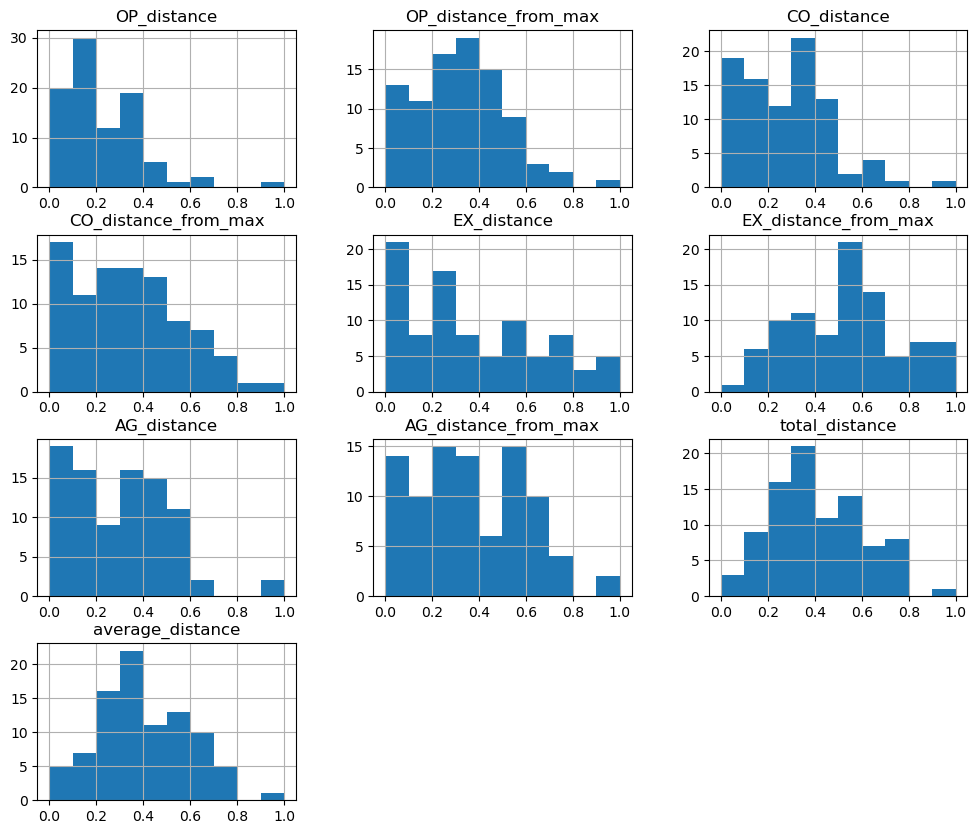

In [116]:
# Define the columns to normalize
columns_to_normalize = [
    'OP_distance', 'OP_distance_from_max', 'CO_distance', 'CO_distance_from_max',
    'EX_distance', 'EX_distance_from_max', 'AG_distance', 'AG_distance_from_max',
    'total_distance', 'average_distance'
]

# Create a new DataFrame with normalized columns
merged_df_norm = merged_df.copy()

# Normalize the specified columns
for column in columns_to_normalize:
    merged_df_norm[column] = (merged_df_norm[column] - merged_df_norm[column].min()) / (merged_df_norm[column].max() - merged_df_norm[column].min())

merged_df_norm[columns_to_normalize].hist(figsize= (12,10))


In [124]:
# Extract rows where both 'EX_distance_from_max' and 'average_distance' are <= 0.7
filtered_df = merged_df_norm[(merged_df_norm['EX_distance_from_max'] <= 0.7) & (merged_df_norm['average_distance'] <= 0.6)]

# Optional: Calculate the percentage of rows meeting the condition
percentage = (len(filtered_df) / len(merged_df_norm)) * 100
print(f"Percentage of rows meeting the condition: {percentage:.2f}%")


Percentage of rows meeting the condition: 70.00%



Mixed Effects Model Results for EX:
                             Mixed Linear Model Regression Results
Model:                          MixedLM              Dependent Variable:              Ads_EX_1 
No. Observations:               90                   Method:                          REML     
No. Groups:                     90                   Scale:                           515.1420 
Min. group size:                1                    Log-Likelihood:                  -429.2133
Max. group size:                1                    Converged:                       Yes      
Mean group size:                1.0                                                            
-----------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                       

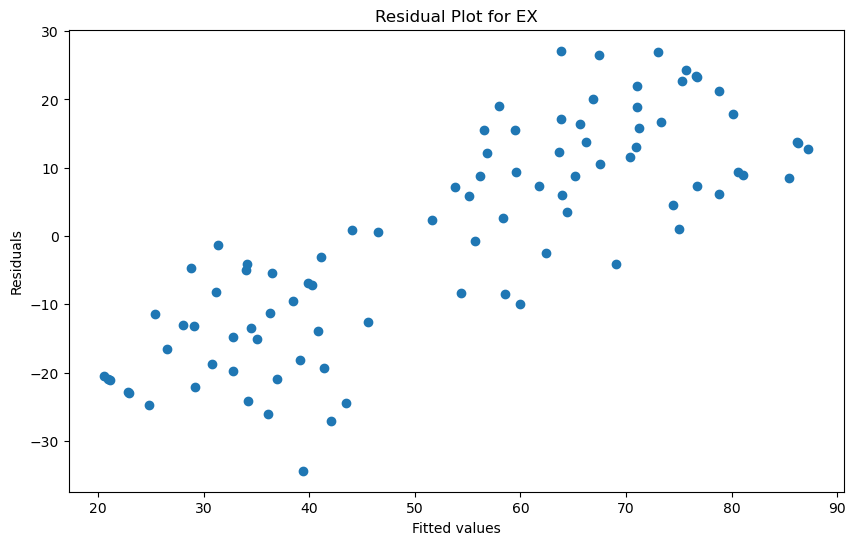


Mixed Effects Model Results for EX:
                              Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               Ads_EX_1
No. Observations:                90                    Method:                           REML    
No. Groups:                      56                    Scale:                            0.0000  
Min. group size:                 1                     Log-Likelihood:                   -60.2859
Max. group size:                 4                     Converged:                        Yes     
Mean group size:                 1.6                                                             
-------------------------------------------------------------------------------------------------
                                                     Coef.   Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------------
Intercept    

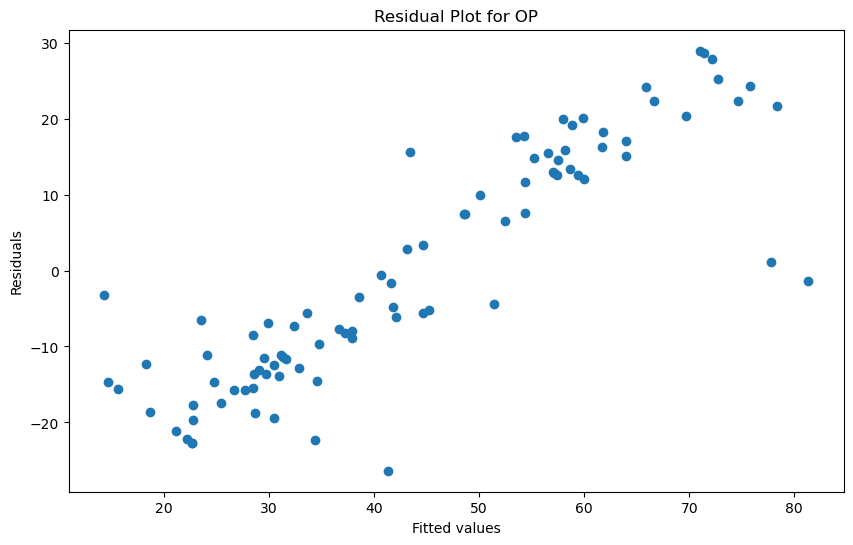


Mixed Effects Model Results for OP:
                              Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               Ads_OP_1
No. Observations:                 90                    Method:                           REML    
No. Groups:                       56                    Scale:                            0.0000  
Min. group size:                  1                     Log-Likelihood:                   -44.9897
Max. group size:                  4                     Converged:                        Yes     
Mean group size:                  1.6                                                             
--------------------------------------------------------------------------------------------------
                                                     Coef.   Std.Err.    z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------------------------------
Inte

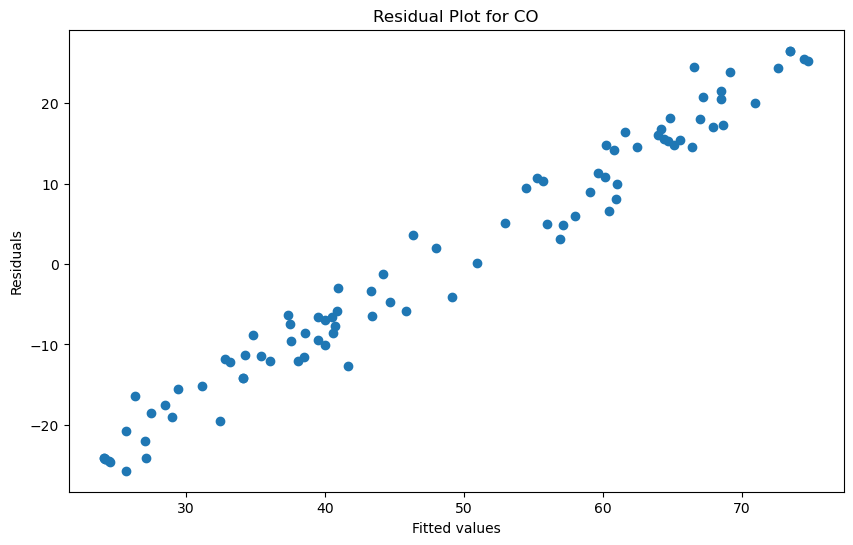


Mixed Effects Model Results for CO:
                              Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               Ads_CO_1
No. Observations:                 90                    Method:                           REML    
No. Groups:                       56                    Scale:                            0.0000  
Min. group size:                  1                     Log-Likelihood:                   -41.1786
Max. group size:                  5                     Converged:                        Yes     
Mean group size:                  1.6                                                             
--------------------------------------------------------------------------------------------------
                                                     Coef.   Std.Err.    z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------------------------------
Inte

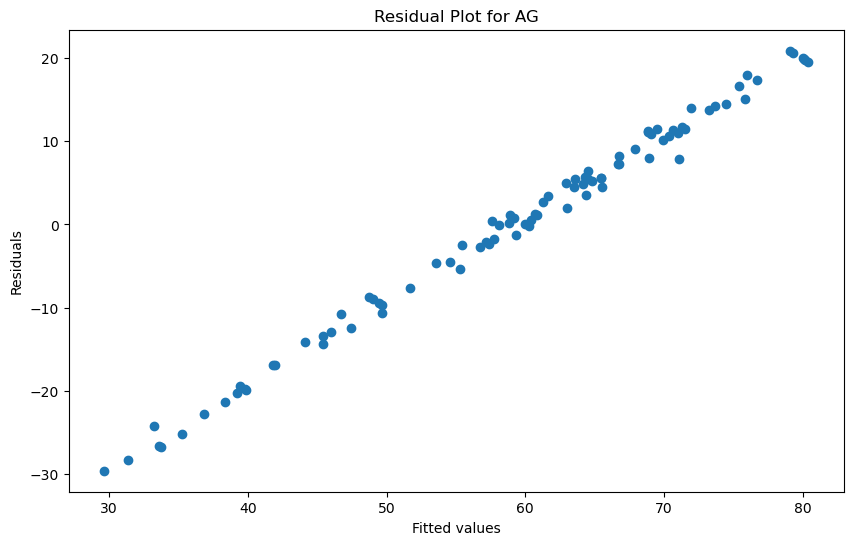


Mixed Effects Model Results for AG:
                              Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               Ads_AG_1
No. Observations:                90                    Method:                           REML    
No. Groups:                      57                    Scale:                            0.0000  
Min. group size:                 1                     Log-Likelihood:                   -55.7015
Max. group size:                 4                     Converged:                        Yes     
Mean group size:                 1.6                                                             
-------------------------------------------------------------------------------------------------
                                                     Coef.   Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------------
Intercept    

In [139]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

data = merged_df

# ResponseIdを文字列に変換
data['ResponseId'] = data['ResponseId'].astype(str)

# データの前処理
traits = ['EX', 'OP', 'CO', 'AG']
for trait in traits:
    data[f'{trait}_distance_from_max_scaled'] = StandardScaler().fit_transform(data[[f'{trait}_distance_from_max']])

data['average_distance_scaled'] = StandardScaler().fit_transform(data[['average_distance']])

# 混合効果モデルの構築
def run_mixed_model(data, trait):
    ad_preference = f'Ads_{trait}_1'
    formula = (f"{ad_preference} ~ {trait}_distance_from_max_scaled + average_distance_scaled + "
               f"{trait}_distance_from_max_scaled:average_distance_scaled")
    
    model = smf.mixedlm(formula, data, groups=data['ResponseId'])
    results = model.fit()
    
    print(f"\nMixed Effects Model Results for {trait}:")
    print(results.summary())
    
    return results

# 効果分析
def analyze_effects(results, data, trait):
    trait_effect = results.params[f'{trait}_distance_from_max_scaled']
    avg_distance_effect = results.params['average_distance_scaled']
    interaction_effect = results.params[f'{trait}_distance_from_max_scaled:average_distance_scaled']
    
    print(f"\nEffect Analysis for {trait}:")
    print(f"Effect of {trait} distance from max: {trait_effect}")
    print(f"Effect of average distance: {avg_distance_effect}")
    print(f"Interaction effect: {interaction_effect}")
    
    # 統計的検定
    for effect in [f'{trait}_distance_from_max_scaled', 'average_distance_scaled', f'{trait}_distance_from_max_scaled:average_distance_scaled']:
        t_stat = results.tvalues[effect]
        p_value = results.pvalues[effect]
        print(f"\n{effect}:")
        print(f"T-statistic: {t_stat}")
        print(f"P-value: {p_value}")

# メインの分析ループ
for trait in traits:
    # 混合効果モデル
    results = run_mixed_model(data, trait)
    
    # 効果分析
    analyze_effects(results, data, trait)
    
    # 多重共線性のチェック
    X = sm.add_constant(data[[f'{trait}_distance_from_max_scaled', 'average_distance_scaled']])
    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\nVIF:\n", vif)

    # モデル診断（残差プロット）
    plt.figure(figsize=(10, 6))
    plt.scatter(results.fittedvalues, results.resid)
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot for {trait}')
    plt.show()

    # 頑健性チェック（ブートストラップ）
    # Bootstrap manually since MixedLMResults does not have a bootstrap method
    bootstrapped_params = []
    for _ in range(100):
        sample_indices = np.random.choice(data.index, size=len(data), replace=True)
        sample_data = data.loc[sample_indices]
        sample_results = run_mixed_model(sample_data, trait)
        bootstrapped_params.append(sample_results.params)
    
    bootstrapped_params_df = pd.DataFrame(bootstrapped_params)
    print("\nBootstrap Results:")
    print(bootstrapped_params_df.describe())

# linear regression

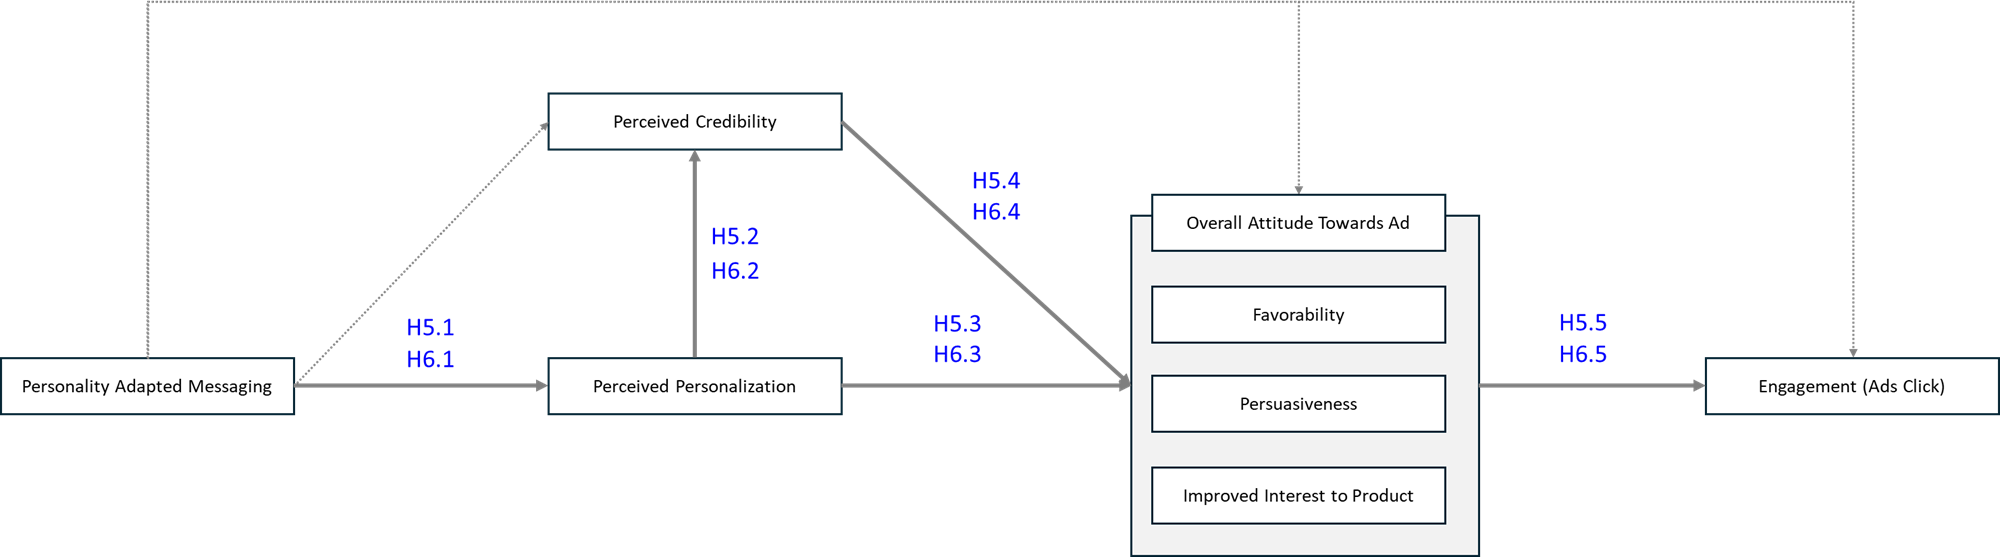

Features to be regressed:
1. [y] each of the constructs(same questions for 4 different(big5) personalized contents) vs [X] big5 distances, controlling for socioeconomic 
2. [y] 'perceived_credibility' scores for each of 4 versions vs [X] 'perceived_personalization' scores for each of 4 versions & matched big5 scores for each of 4 versions, controlling for socioeconomic 
3. [y] 'overall_attitude' scores for each of 4 versions vs [X] 'perceived_personalization' scores for each of 4 versions & (moderator) 'perceived_credibility' scores for each of 4 versions & matched big5 scores for each of 4 versions, controlling for socioeconomic 
4. [y] 'ads_engagement' scores for each of 4 versions vs [X] 'overall_attitude' scores for each of 4 versions & matched big5 scores for each of 4 versions, controlling for socioeconomic 